In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import glob
from random import randint



In [14]:
from importlib import reload
import utils; reload(utils)
from utils import *


## Dataset Exploration
Labeled images of vehicles and non-vehicles were obtained from [KITTI vision benchmark suit](http://www.cvlibs.net/datasets/kitti/) and [GTI vehicle image database](http://www.gti.ssr.upm.es/data/Vehicle_database.html).  
You can download the dataset for vehicles [here](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip) and non-vehicles [here](https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip).  

-----------------------------------------------------------------------------------------------------------------------------------

Total vehicle images = 8792   
Total non-vehicle images = 8968  
Image size = 64 $\times$ 64   

The vehicle images in the database are divided as per the angle in which the images were taken. The images also reflect different lighting condiditons.   
The non-vehicle images consists of roads, trees, traffic signs, pavements or asphalts. 

In [3]:
vehicles_dir = glob.glob("./vehicles/*/*.png", recursive=True)
non_vehicles_dir = glob.glob("./non-vehicles/**/*.png", recursive=True)

print(f"The number of vehicle images = {len(vehicles_dir)}")
print(f"The number of non-vehicle images = {len(non_vehicles_dir)}")

get_img_size(vehicles_dir)
get_img_size(non_vehicles_dir)

The number of vehicle images = 8792
The number of non-vehicle images = 8968
The size of image is 64 by 64
The size of image is 64 by 64
The size of image is 64 by 64
The size of image is 64 by 64


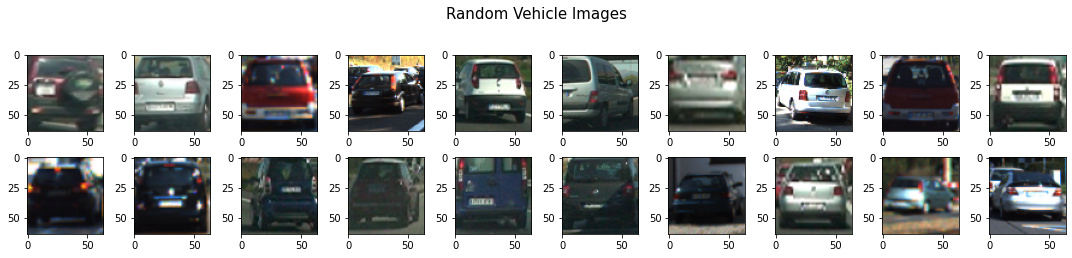

In [30]:
%run utils.py
show_random_images(image_dir = vehicles_dir,title = "Random Vehicle Images")

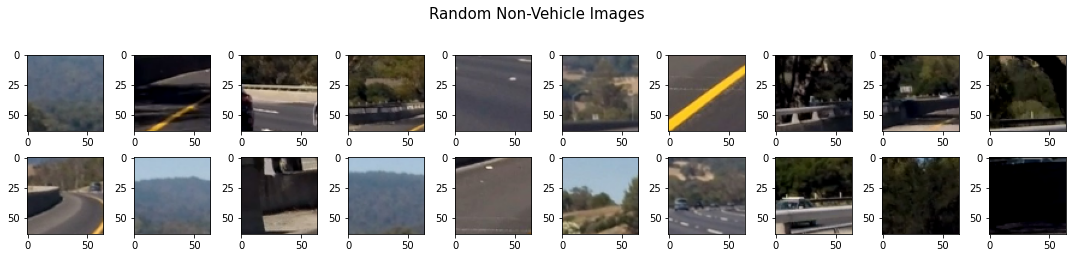

In [31]:
show_random_images(image_dir = non_vehicles_dir,title = "Random Non-Vehicle Images")